# Phase planes of Bifurcation Graph Ko

In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [24]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        ax.savefig(fig_name+'.png',dpi=rast)
        fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        ax.savefig(fig_name+'.png')
        fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [6]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [8]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

# Defining setup for the continuations

### Defining neuron model

In [9]:
## Loading neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


### Extracting Bif graph information from saved object

In [10]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']

# Now we want to extract phase planes in each of the regions

### First we extract the limit cycle and the steady states for the specific currents we are interested in

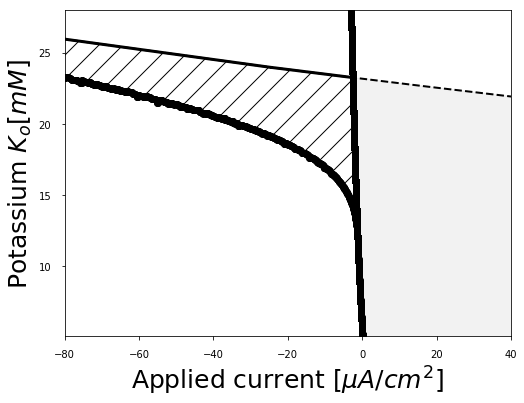

In [11]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('Potassium $K_o[mM]$',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()




In [12]:
## Applied currents in which we are interested
t_I_app_specf=[-3.0,-1.39,0.0]

##############################################3
### Finding phase plane in the bistable region
I_app=-30;K_o=12.5
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
autobifpart['K_o']=K_o
### Extracting inistates & expressions
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
cwd_nonTemp = os.getcwd()
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app   
    r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
        UZSTOP= {})
    
os.chdir(cwd_nonTemp)

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 2: 12.5, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -1.96875E+01   2.43316E+02  -2.43314E+02   2.80372E-18   2.78994E-21   1.00000E+00
   1     2        3  -9.37143E+00   1.43851E+02  -1.43847E+02   7.05583E-09   1.54461E-10   1.00000E+00
   1  6179  UZ    4  -3.00000E+00   8.24206E+01  -8.24146E+01   2.35245E-03   4.8192

In [13]:
s1HB = r1_fwd_sn_I_app_specf('HB')[0]
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})
    
os.chdir(cwd_nonTemp)


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 2: 12.5, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       period    
  21     3  BP   32   4.27283E+02   3.75331E+01  -3.75079E+01   6.14842E-01   6.15385E-01   1.28395E-01   1.23014E+00
  21  3000       33   1.28313E+02   4.45559E+01  -1.28898E+01   5.97851E-01   9.41980E-01   2.01753E-01   1.48887E+00
  21  4342  UZ   34  -5.07596E-08   5.7976

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [14]:
## Extracting all the steady states and limit cycle onsets for the applied currents t_I_app_specf
ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')

In [15]:
## Extracting information from auto objects into numpy arrays
# Limit cycles
v_I_app=[]
v_one_sim_s=[]
v_one_sim=[]
for lc_Iapp_specfi in lc_Iapp_specf:
    one_sim=[]
    one_sim_s=[]
    for i_s in lc_Iapp_specfi.coordnames:
        one_sim.append(lc_Iapp_specfi[i_s])
        one_sim_s.append(i_s)
    v_I_app.append(lc_Iapp_specfi.PAR[strIapp])
    v_one_sim_s.append(one_sim_s)
    v_one_sim.append(one_sim)


In [16]:
# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

In [17]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
## Extracting information from auto objects into numpy arrays
# steady states
v_Jeival=[]
v_Jeivect=[]
v_saddle_point=[]
v_I_app_ss=[]
for ao_saddle_point in ss_I_app_specf:
    ### Getting position
    saddle_point=ao_saddle_point.coordarray
    ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
    v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
    J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
    Jfoo = lambdify(ao_saddle_point.coordnames,J)
    Jmat=Jfoo(*saddle_point)
    m_JMat=fixing_jmat(Jmat)
    Jeival, Jeivect = LA.eig(m_JMat)
    v_saddle_point.append(saddle_point)
    v_Jeival.append(Jeival)
    v_Jeivect.append(Jeivect)
    v_I_app_ss.append(ao_saddle_point.PAR[strIapp])

# Results: Phase planes in each of the regions

In [18]:
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

-1.3900000003
12.5
-1.4040155343
12.5
-1.3899998074
12.5
-5.0759607629e-08
12.5


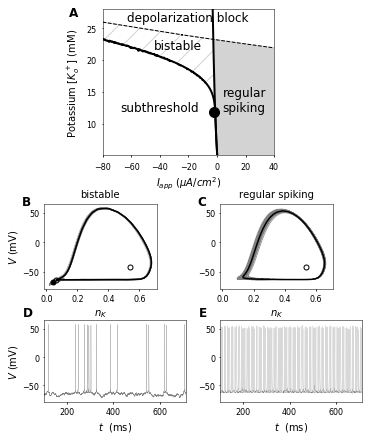

<Figure size 410.4x360 with 0 Axes>

'verticalPhase_diagrams_BistablePlane_wTrajectory_MTM_W_sPNAs_Temp_snapshot_p0K_o_12.5_Iapp_-3_-1_0'

In [25]:
fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_wide/0.8+0.1))
axpl = plt.subplot2grid((91,11), (0, 2), colspan=6,rowspan=34)
ax1l = plt.subplot2grid((91,11), (45, 0), colspan=4,rowspan=20)
ax1m = plt.subplot2grid((91,11), (45, 6), colspan=4,rowspan=20,sharex=ax1l,sharey=ax1l)
ax1l2 = plt.subplot2grid((91,11), (72, 0), colspan=5,rowspan=19,sharey=ax1l)
ax1m2 = plt.subplot2grid((91,11), (72, 6), colspan=5,rowspan=19,sharex=ax1l2,sharey=ax1l)

sigma_v=[1.0]

xlim=[-80,40]
ylim=[5.1,28]
axpl.set_xlim(xlim)
axpl.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],linewidth=2,color=[0,0,0])
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],linewidth=2,color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=1,color=[0,0,0])


## Finding Co-dimension2 bifurcation
snl_ko=b[b.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]
snl_iapp=bx[bx.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=1., edgecolor='lightgray')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='lightgray')
## Plot snl
axpl.plot(snl_iapp,snl_ko,'o',markersize=10,color='black')
##### Plot axes
axpl.set_ylabel('Potassium $[K_o^+]$ (mM)')
axpl.set_xlabel('$I_{app}$ $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=5)
axpl.tick_params(axis='x', pad=5)



###### Phase planes

ax=[ax1l,ax1m]
ax_0=[ax1l2,ax1m2]

for ii_iapi in range(len(t_I_app_specf))[1:]:
    ### Plot limit cycle onset
    ax[ii_iapi-1].set_title(strIapp+' = '+ str(t_I_app_specf[ii_iapi]))
    for ii_api_lc in range(len(v_I_app)):
        if abs(v_I_app[ii_api_lc]-t_I_app_specf[ii_iapi])<0.1:
            I_app=-1.0
            bifpar={}
            bifpar[strIapp] = [str(t_I_app_specf[ii_iapi])+"* uA/cm2"]
            bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
            name='SIM_'+model_name+'_I_app_'+bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')]+'_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_sigma_'+str(sigma_v[0])
            if os.path.isfile(dir_sims+name+'.pkl'):
                f=open(dir_sims+name+'.pkl', 'rb')
                d_save_sim=pickle.load(f)
                s_results=d_save_sim['s_results']
                v_results=d_save_sim['v_results']
                fp_event_t=d_save_sim['fp_event']
                spikes_t=d_save_sim['spikes']
                M_pars=d_save_sim['pars']
                idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
                idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
                idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n_K'][0]
                ax[ii_iapi-1].plot(v_results[idx_nk,:][100000:int(len(v_results[idx_nk,:])/7)],v_results[idx_v,:][100000:int(len(v_results[idx_nk,:])/7)],label='trajectory',color='grey',linewidth=matplotlib.rcParams['axes.linewidth']*0.3,rasterized=True)
                ax_0[ii_iapi-1].plot(v_results[idx_t,:][100000:int(len(v_results[idx_nk,:])/7)],v_results[idx_v,:][100000:int(len(v_results[idx_nk,:])/7)],label='trajectory',color='grey',linewidth=matplotlib.rcParams['axes.linewidth']*0.3,rasterized=True)
            try:
                ax[ii_iapi-1].plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],color='black', rasterized=True)
                print(v_I_app[ii_api_lc])
                print(K_o)
            except:
                pass
    ### Plot ss
    for ii_api_ss in range(len(v_I_app_ss)):
        if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<0.1:
            if any(v_Jeival[ii_api_ss].real>0):
                ax[ii_iapi-1].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=5,mfc='none',color='black')
            else:
                ax[ii_iapi-1].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=5,color='black')
                print(v_I_app_ss[ii_api_ss])
                print(K_o)
    ax[ii_iapi-1].set_xlabel('$'+v_one_sim_s[ii_iapi][1]+'$')#     axpl.plot(t_I_app_specf[ii_iapi]-0.25,K_o-0.25,'o',color='grey')
    ax_0[ii_iapi-1].set_xlabel('$'+s_results[idx_t]+'$  (ms)')

ax_0[-1].set_xlim([min(v_results[idx_t,:][100000:int(len(v_results[idx_nk,:])/7)]),max(v_results[idx_t,:][100000:int(len(v_results[idx_nk,:])/7)])])
ax[0].set_ylabel('$V$ (mV)',labelpad=2)
ax_0[0].set_ylabel('$V$ (mV)',labelpad=2)

txt0='SNL'
txt1=' Ko='+"{0:.2f}".format(snl_ko)
txt2='$I_{app}=$'+"{0:.2f}".format(snl_iapp)


axpl.annotate('bistable', (snl_iapp,snl_ko),xytext=(0.3,0.725), textcoords='axes fraction')
axpl.annotate('regular\nspiking', (snl_iapp,snl_ko),xytext=(0.7,0.3), textcoords='axes fraction')
axpl.annotate('subthreshold', (snl_iapp,snl_ko),xytext=(0.1,0.3), textcoords='axes fraction')
axpl.annotate('depolarization block', (snl_iapp,snl_ko),xytext=(0.14,0.92), textcoords='axes fraction')


ax1l.set_title('bistable')
ax1m.set_title('regular spiking')

############################################
### Labels
############################################
v_ax=[axpl,ax1l,ax1m,ax1l2,ax1m2]
import string
ni=0
for n, axs in enumerate(v_ax):
    if n==0:
        axs.text(-0.2, 0.95, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    if n==1 or n==2:
        axs.text(-0.2, 0.98, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=matplotlib.rcParams["font.size"], weight='bold')
    if n==3 or n==4:
        axs.text(-0.15, 1.05, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=matplotlib.rcParams["font.size"], weight='bold')




fig_name='verticalPhase_diagrams_BistablePlane_wTrajectory_'+model_name+'K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_Iapp_'+str(int(t_I_app_specf[0]))+'_'+str(int(t_I_app_specf[1]))+'_'+str(int(t_I_app_specf[2]))
md_dir={}
md_dir['Title']='phase diagrams in bistable region'+model_name
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(fig01,'./Figs/'+fig_name+'v_thesis',md_dir,raster=300)
plt.show()
fig_name